
수집한 인스타그램 팀버랜드 6인치 (23.07.01 ~ 24.07.01) 데이터를 이용하여 시계열 데이터 예측



LGBM 모델 사용.

In [2]:
import pandas as pd

# CSV 파일에서 데이터 로드 (예시)
data = pd.read_csv('팀버랜드 6인치 (23.07.01-24.07.01).csv')

# 데이터 확인
data.head()

,contents,likes,comments,date,hashtags
0,레인부츠 대신 방수부츠는 어떠신지요?🕴️🕴️ 셔츠 : @lafudgestore (협...,304,108,2023년 07월 05일,['#바이데센']
1,1년 묵은 적금샷으로 리스따뜨,200,47,2023년 07월 12일,[' ']
2,⋰˚✩ 𐌔𐌏𐌋𐌃 𐌏𝖴𐌕 ⋰˚✩ *색상은 착용샷 참고해주세요. PRICE : ❌❌❌ ...,13,1,2023년 08월 03일,"['#팀버랜드', '#TIMBERLAND', '#팀버랜드워커', '#팀버랜드6인치'..."
3,"낭만적이네요. 이 조명, 온도, 습도",여러 명,71,2023년 08월 06일,"['#팀버랜드', '#팀버랜드워커', '#팀버랜드6인치', '#팀버랜드']"
4,▫️오늘 업데이트된 제품입니다. #timberland #팀버랜드6인치 #armani...,여러 명,8,2023년 08월 08일,"['#timberland', '#팀버랜드6인치', '#armaniexchange']"


In [3]:
# 날짜 문자열 정규화 후 형식 변환
data['date'] = data['date'].str.replace('년', '-').str.replace('월', '-').str.replace('일', '')
data['date'] = data['date'].str.replace(' ', '')  # 공백 제거

In [4]:
data['date']

0      2023-07-05
1      2023-07-12
2      2023-08-03
3      2023-08-06
4      2023-08-08
          ...    
150    2024-06-28
151    2024-06-28
152    2024-06-29
153    2024-06-30
154    2024-06-30
Name: date, Length: 155, dtype: object

In [5]:
# 날짜 형식 변환

# 게시 날짜를 datetime 형식으로 변환
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [6]:
data.head()

,contents,likes,comments,hashtags
date,,,,
2023-07-05,레인부츠 대신 방수부츠는 어떠신지요?🕴️🕴️ 셔츠 : @lafudgestore (협...,304,108,['#바이데센']
2023-07-12,1년 묵은 적금샷으로 리스따뜨,200,47,[' ']
2023-08-03,⋰˚✩ 𐌔𐌏𐌋𐌃 𐌏𝖴𐌕 ⋰˚✩ *색상은 착용샷 참고해주세요. PRICE : ❌❌❌ ...,13,1,"['#팀버랜드', '#TIMBERLAND', '#팀버랜드워커', '#팀버랜드6인치'..."
2023-08-06,"낭만적이네요. 이 조명, 온도, 습도",여러 명,71,"['#팀버랜드', '#팀버랜드워커', '#팀버랜드6인치', '#팀버랜드']"
2023-08-08,▫️오늘 업데이트된 제품입니다. #timberland #팀버랜드6인치 #armani...,여러 명,8,"['#timberland', '#팀버랜드6인치', '#armaniexchange']"


In [7]:
# 날짜 기준으로 데이터 정렬
data = data.sort_values(by='date')

In [8]:
# 좋아요 수와 댓글 수를 정수형으로 변환

# 좋아요 수 '여러 명'은 임의로 100, 댓글 수 '댓글 없음'은 0으로 설정
def numeric(value):
    if pd.isna(value):
        return np.nan
    
    # 천 단위 구분 기호 제거
    value = str(value).replace(',', '')  

    if value == '여러 명':
        return 100
    
    elif value == '댓글 없음':
        return 0
    
    else:
        return int(value)

# '여러 명'과 '댓글 없음' 문자열을 숫자로 변환
data['likes'] = data['likes'].apply(numeric)
data['comments'] = data['comments'].apply(numeric)

In [9]:
# 시계열 데이터 생성 위한, 날짜를 기준으로 데이터를 집계

# 월별로 좋아요 수, 댓글 수 집계
monthly_data = data.resample('M').sum().reset_index()
monthly_data.rename(columns={'likes': 'likes', 'comments': 'comments'}, inplace=True)

In [10]:
# 날짜를 숫자로 변환 (모델 입력으로 사용하기 위함)
monthly_data['month'] = monthly_data['date'].apply(lambda x: x.toordinal())

In [11]:
# 특징(Feature)와 타겟(Target) 정의
X = monthly_data[['month']]
y_likes = monthly_data['likes']
y_comments = monthly_data['comments']

In [12]:
from sklearn.model_selection import train_test_split

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train_likes, y_test_likes = train_test_split(X, y_likes, 
                                                                test_size=0.2, random_state=42)

X_train, X_test, y_train_comments, y_test_comments = train_test_split(X, y_comments, 
                                                                      test_size=0.2, random_state=42)

In [13]:
# LGBM 모델 학습을 위한 파라미터 설정
params = {
    'objective': 'regression', # 회귀 문제 설정
    'metric': 'rmse', # 모델 평가 지표
    'boosting_type': 'gbdt',
    'learning_rate': 0.05, # 학습률 조정
    'num_leaves': 70, # 노드 수 조정
    'max_depth': 15,  # 최대 깊이 조정
    'verbose': -1 # 로그 출력 최소화
}

In [14]:
import lightgbm as lgb

# 좋아요 수 모델 학습
lgb_train_likes = lgb.Dataset(X_train, label=y_train_likes)
lgb_eval_likes = lgb.Dataset(X_test, label=y_test_likes, reference=lgb_train_likes)

# 조기 종료 콜백 추가 (100 라운드 동안 성능 향상이 없으면 조기 종료)
callbacks = [lgb.callback.early_stopping(stopping_rounds=100)]

# 모델 학습
model_likes = lgb.train(params, lgb_train_likes, num_boost_round=2000, valid_sets=[lgb_eval_likes], callbacks=callbacks)

# 댓글 수 모델 학습
lgb_train_comments = lgb.Dataset(X_train, label=y_train_comments)
lgb_eval_comments = lgb.Dataset(X_test, label=y_test_comments, reference=lgb_train_comments)

# 모델 학습
model_comments = lgb.train(params, lgb_train_comments, num_boost_round=2000, valid_sets=[lgb_eval_comments], callbacks=callbacks)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 2553.82
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 181.279


In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error

# 좋아요 수 예측
y_pred_likes = model_likes.predict(X_test, num_iteration=model_likes.best_iteration)
rmse_likes = np.sqrt(mean_squared_error(y_test_likes, y_pred_likes))

# 댓글 수 예측
y_pred_comments = model_comments.predict(X_test, num_iteration=model_comments.best_iteration)
rmse_comments = np.sqrt(mean_squared_error(y_test_comments, y_pred_comments))

# 예측 성능 출력
print(f"RMSE for Likes Prediction: {rmse_likes}")
print(f"RMSE for Comments Prediction: {rmse_comments}")

RMSE for Likes Prediction: 2553.8192918271725
RMSE for Comments Prediction: 181.2790972812671


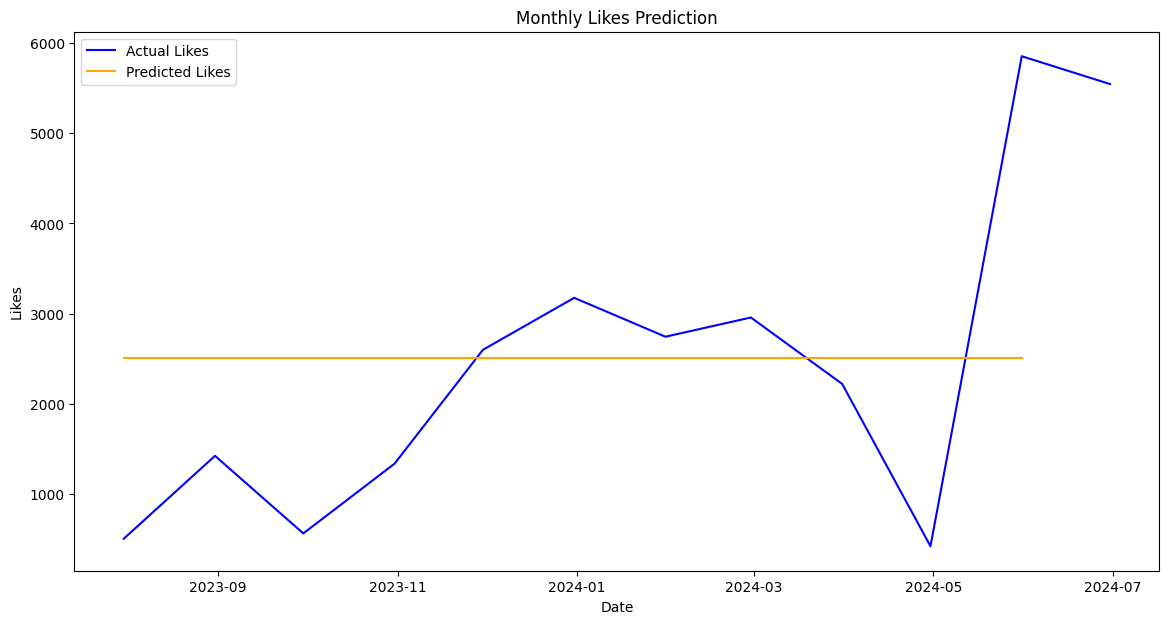

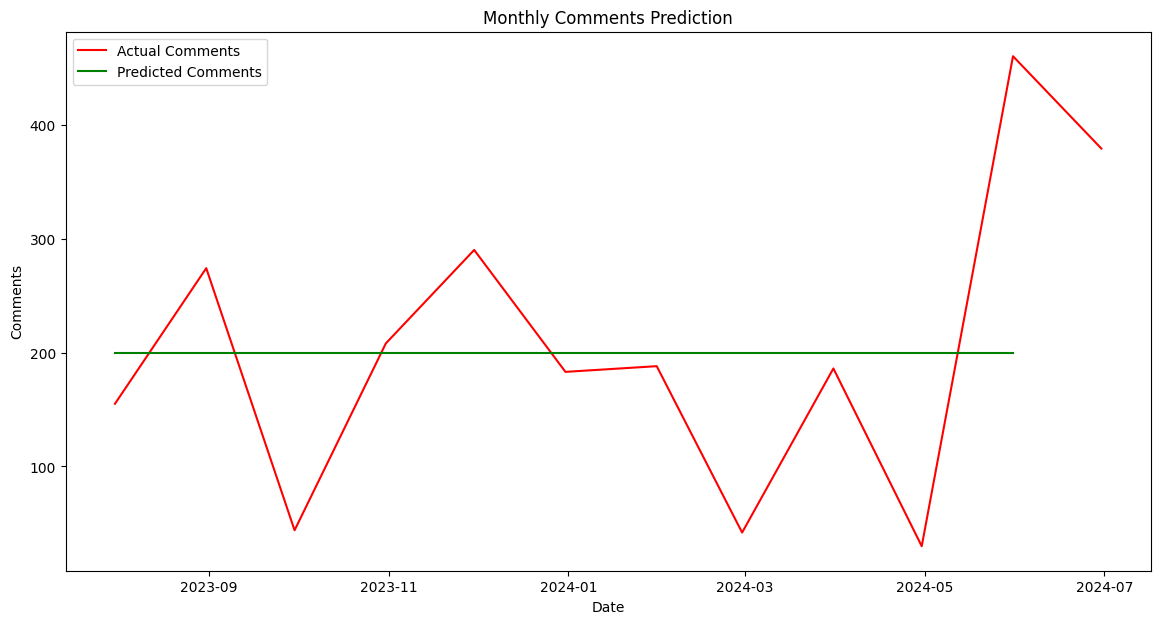

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 결과 시각화

# 좋아요 수 예측 시각화
plt.figure(figsize=(14, 7))
plt.plot(monthly_data['date'], monthly_data['likes'], label='Actual Likes', color='b')
plt.plot(monthly_data['date'].iloc[X_test.index], y_pred_likes, label='Predicted Likes', color='orange')
plt.title('Monthly Likes Prediction')
plt.xlabel('Date')
plt.ylabel('Likes')
plt.legend()
plt.show()

# 댓글 수 예측 시각화
plt.figure(figsize=(14, 7))
plt.plot(monthly_data['date'], monthly_data['comments'], label='Actual Comments', color='r')
plt.plot(monthly_data['date'].iloc[X_test.index], y_pred_comments, label='Predicted Comments', color='green')
plt.title('Monthly Comments Prediction')
plt.xlabel('Date')
plt.ylabel('Comments')
plt.legend()
plt.show()

---

Random Forest 모델 사용.

In [27]:
import pandas as pd

# CSV 파일에서 데이터 로드 (예시)
data = pd.read_csv('팀버랜드 6인치 (23.07.01-24.07.01).csv')

# 날짜 문자열 정규화 후 형식 변환
data['date'] = data['date'].str.replace('년', '-').str.replace('월', '-').str.replace('일', '')
data['date'] = data['date'].str.replace(' ', '')  # 공백 제거

data['date']

# 날짜 형식 변환

# 게시 날짜를 datetime 형식으로 변환
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# 날짜 기준으로 데이터 정렬
data = data.sort_values(by='date')

# 좋아요 수와 댓글 수를 정수형으로 변환

# 좋아요 수 '여러 명'은 임의로 100, 댓글 수 '댓글 없음'은 0으로 설정
def numeric(value):
    if pd.isna(value):
        return np.nan
    
    # 천 단위 구분 기호 제거
    value = str(value).replace(',', '')  

    if value == '여러 명':
        return 100
    
    elif value == '댓글 없음':
        return 0
    
    else:
        return int(value)

# '여러 명'과 '댓글 없음' 문자열을 숫자로 변환
data['likes'] = data['likes'].apply(numeric)
data['comments'] = data['comments'].apply(numeric)

In [28]:
from sklearn.ensemble import RandomForestRegressor

# 월별로 좋아요 수, 댓글 수 집계
monthly_data = data.resample('M').sum().reset_index()
monthly_data.rename(columns={'likes': 'likes', 'comments': 'comments'}, inplace=True)

# 날짜를 숫자로 변환
monthly_data['month'] = monthly_data['date'].apply(lambda x: x.toordinal())

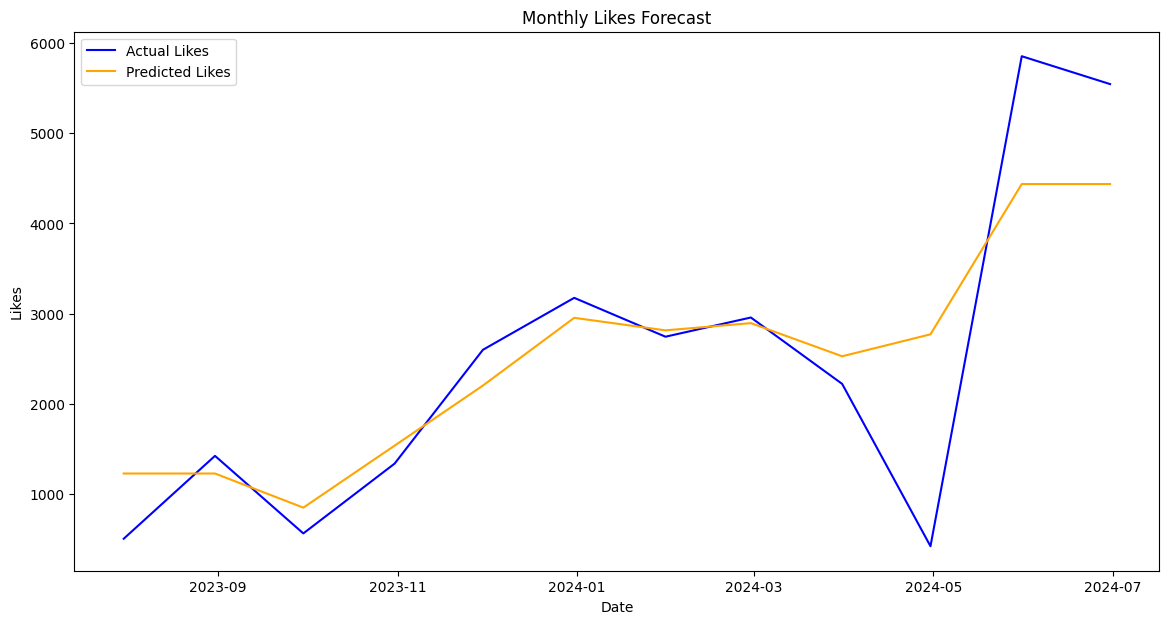

In [29]:
# 좋아요 수 예측

# 특징 및 타겟 정의
X = monthly_data[['month']]
y_likes = monthly_data['likes']

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train_likes, y_test_likes = train_test_split(X, y_likes, test_size=0.2, random_state=42)

# Random Forest 모델 학습
rf_model_likes = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_likes.fit(X_train, y_train_likes)

# 예측
y_pred_likes = rf_model_likes.predict(X)

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(monthly_data['date'], monthly_data['likes'], label='Actual Likes', color='b')
plt.plot(monthly_data['date'], y_pred_likes, label='Predicted Likes', color='orange')
plt.title('Monthly Likes Forecast')
plt.xlabel('Date')
plt.ylabel('Likes')
plt.legend()
plt.show()

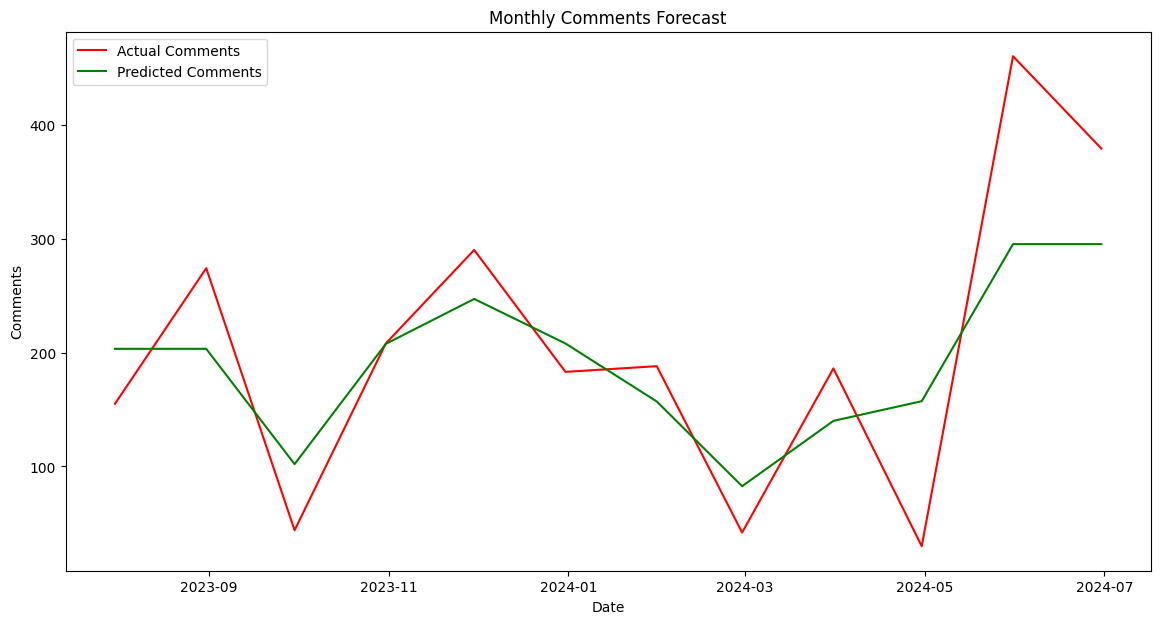

In [30]:
# 댓글 수 예측

# 특징 및 타겟 정의
y_comments = monthly_data['comments']

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train_comments, y_test_comments = train_test_split(X, y_comments, test_size=0.2, random_state=42)

# Random Forest 모델 학습
rf_model_comments = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_comments.fit(X_train, y_train_comments)

# 예측
y_pred_comments = rf_model_comments.predict(X)

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(monthly_data['date'], monthly_data['comments'], label='Actual Comments', color='r')
plt.plot(monthly_data['date'], y_pred_comments, label='Predicted Comments', color='green')
plt.title('Monthly Comments Forecast')
plt.xlabel('Date')
plt.ylabel('Comments')
plt.legend()
plt.show()